<a href="https://colab.research.google.com/github/bhimrazy/unet/blob/main/Unet_Implemenation_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing basic libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm


# importing torch libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

# setting device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Device: {device} and Torch version: {torch.__version__}')

Device: cuda and Torch version: 1.13.1+cu116


In [ ]:
# downloading and preparing dataset
!rm -rf unet dataset

!git clone https://github.com/zhixuhao/unet
!mv "unet/data/membrane" "dataset"
!rm -rf unet


Cloning into 'unet'...
remote: Enumerating objects: 394, done.
remote: Total 394 (delta 0), reused 0 (delta 0), pack-reused 394
Receiving objects: 100% (394/394), 44.92 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (80/80), done.


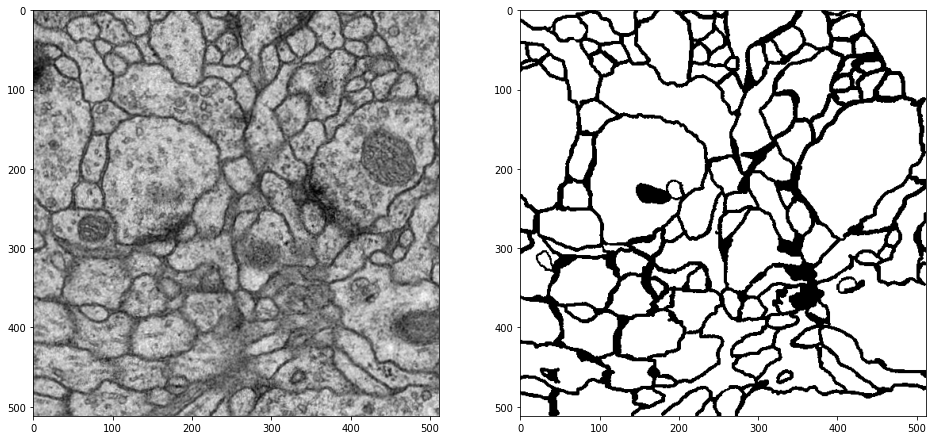

In [ ]:
# showing up train image
img = Image.open("dataset/train/image/0.png")
label = Image.open("dataset/train/label/0.png")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16, 9))
ax1.imshow(img,cmap="gray")
ax2.imshow(label, cmap="gray")
plt.show()

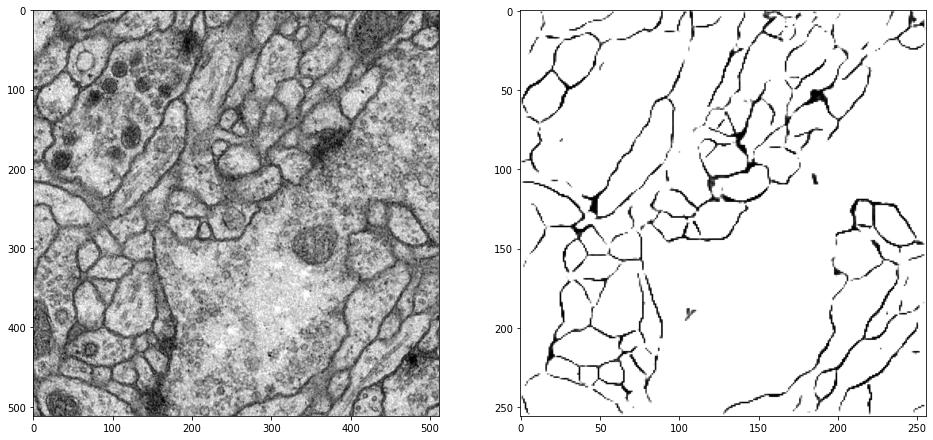

In [ ]:
# showing up test image
img = Image.open("dataset/test/0.png")
label = Image.open("dataset/test/0_predict.png")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16, 9))
ax1.imshow(img,cmap="gray")
ax2.imshow(label, cmap="gray")
plt.show()

In [ ]:
# collecting train and test images
train_imgs = glob.glob("dataset/train/image/*")
train_labels = [img.replace('image','label') for img in train_imgs]

test = glob.glob("dataset/test/*")
test_labels = [img for img in test if "predict" in img]
test_imgs = [img.replace('_predict','') for img in test_labels if "predict" in img]


In [ ]:
len(train_imgs),len(train_labels),len(test_labels),len(test_imgs)

(30, 30, 30, 30)

In [ ]:
# dataset class and dataloaders
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(572),
    # transforms.Resize(512),
    # transforms.Pad(padding=30, padding_mode='reflect'),
    # transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor()
])
mask_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(572),
    # transforms.CenterCrop(388),
    transforms.CenterCrop(560),
    transforms.ToTensor()
])

# transform = transforms.Compose([
#     transforms.Grayscale(),
#     transforms.Resize(572),
#     # transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
#     # transforms.RandomRotation(degrees=15),
#     transforms.GaussianBlur(kernel_size=5),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])

class CellDataset(Dataset):
  def __init__(self,images,labels,transform=None,mask_transform=None):
    self.imgs = images
    self.img_labels = labels
    self.transform = transform
    self.mask_transform = mask_transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self,idx):
        # get the image path and label for the specified index
        img_path = self.imgs[idx]
        label_path = self.img_labels[idx]

        # load the image from the path
        image = Image.open(img_path)
        label = Image.open(label_path)

        # apply transform
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            label = self.mask_transform(label)
        
        # return the image and label as a tuple
        return image, label

# Dataset
TOTAL = len(train_imgs)
BATCH = 5
STEP = TOTAL/BATCH

train_data = CellDataset(images=train_imgs[:10],labels=train_labels[:10], transform=transform, mask_transform=mask_transform )
test_data = CellDataset(images=test_imgs[:10],labels=test_labels[:10], transform=transform, mask_transform=mask_transform )


train_dataloader = DataLoader(train_data, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH, shuffle=True)

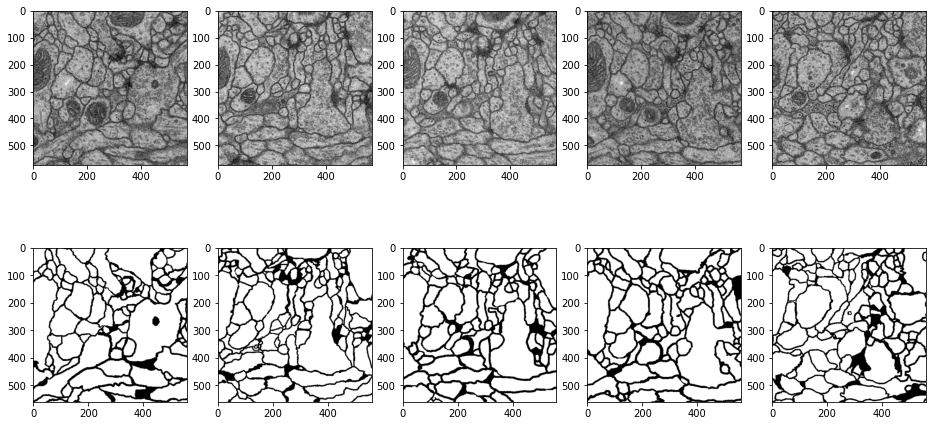

In [ ]:
# Load your data using a PyTorch dataloader
data, labels = next(iter(train_dataloader))

# Create a figure with a grid of subplots
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=BATCH,figsize=(16, 8))

# Plot the images in the subplots
for i, ax in enumerate(ax1):
    # Get the image and label for the current subplot
    image = data[i]

    ax.imshow(image[0],cmap='gray')
    
    # Set the title of the subplot to the label

# Plot the images in the subplots
for i, ax in enumerate(ax2):
    # Get the image and label for the current subplot
    image = labels[i]

    ax.imshow(image[0],cmap='gray')
    
    # Set the title of the subplot to the label    

# # Show the plot
# plt.show()

## U-Net Architecture

The U-Net architecture consists of a contracting path on the left side and an expanding path on the right side.

### Contracting Path
The contracting path is composed of a series of blocks each consisting of:
- Two consecutive convolutional layers
- A max pooling layer

### Expanding Path
The expanding path is composed of a series of blocks each consisting of:
- An upsampling layer
- Two consecutive convolutional layers
- A concatenation with the corresponding feature map from the contracting path

The final layer of the architecture is a single convolutional layer that produces the output segmentation mask.

Note: The exact number of blocks and the number of filters in each layer may vary depending on the specific implementation and the problem being solved.


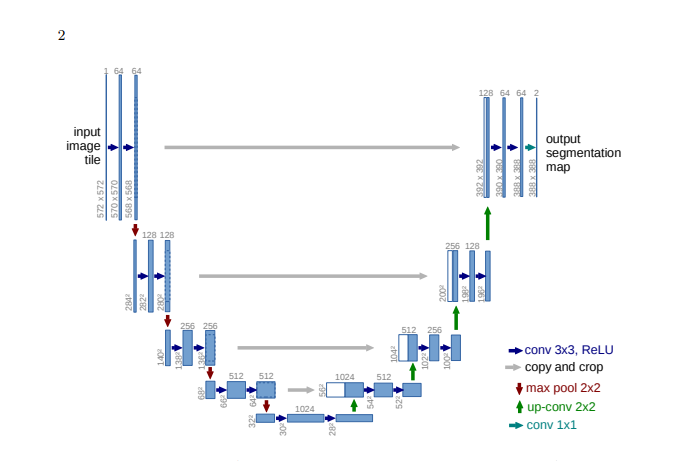

In [ ]:
# config
channels = [1,64,128,256,512,1024]

class ConvBlock(nn.Module):
  """This block consists of:
      - Two consecutive CNN layers (each => conv 3x3, ReLU)
  """
  def __init__(self, in_ch, out_ch):
    super().__init__()

    self.block = nn.Sequential(
          nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,padding=1),
          nn.BatchNorm2d(out_ch),
          nn.ReLU(),
          nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,padding=1),
          nn.BatchNorm2d(out_ch),
          nn.ReLU(),
      )
  def forward(self, x):
    return self.block(x)

class ContractingEncoder(nn.Module):
  """This block consists of:
      - Two consecutive CNN layers (each => conv 3x3, ReLU)
      - Followed by maxpooling (max pool 2x2)
  """
  def __init__(self,channels):
    super().__init__()
    self.encoder_blocks = nn.ModuleList()
    self.max_pool = nn.MaxPool2d(kernel_size=2)

    for i in range(len(channels)-1):
      self.encoder_blocks.append(ConvBlock(channels[i],channels[i+1]))

  def forward(self,x):
    # print("Contracting...")
    features = []
    for enc in self.encoder_blocks:
      x = enc(x)
      features.append(x)
      # print(x.shape)
      x = self.max_pool(x)

    return features

class ExpandingDecoder(nn.Module):
  """This block consists of:
      - Up sampling conv layer (up-conv 2x2 , makes channel half)
      - Concatenation of corresponding cropped feature from contracting path
      - Two consecutive CNN layers (=> conv 3x3, ReLU)
  """
  def __init__(self,channels):
    super().__init__()
    self.decoder_blocks = nn.ModuleList()
    self.up_convs = nn.ModuleList()

    for i in range(len(channels)-1):
      self.up_convs.append(nn.ConvTranspose2d(channels[i],channels[i+1], 2, 2))
      self.decoder_blocks.append(ConvBlock(channels[i],channels[i+1]))

  def crop(self, feature, x):
    _,_,H,W = x.shape
    feature = transforms.CenterCrop([H,W])(feature)
    return feature

  def forward(self, x, encoder_features):
    # print("Expanding...")
    for i,(up_conv, dec) in enumerate(zip(self.up_convs, self.decoder_blocks)):
      x = up_conv(x)
      encoder_feature = self.crop(encoder_features[i],x)
      x = torch.cat([encoder_feature,x],dim=1)
      x = dec(x)

      # print(x.shape)

    return x


class UNet(nn.Module):
  # UNet implementation in pytorch
  def __init__(self,channels=[1,64,128,256,512,1024], n_classes=1):
    super(UNet,self).__init__()
    self.enc_channels = channels
    self.dec_channels = channels[::-1][:-1]

    self.encoder = ContractingEncoder(channels=self.enc_channels)
    self.decoder = ExpandingDecoder(channels=self.dec_channels)

    self.head = nn.Conv2d(self.dec_channels[-1],n_classes,1)

  def forward(self,x):
    encoder_features = self.encoder(x)
    encoder_features = encoder_features[::-1]
    out = self.decoder(encoder_features[0],encoder_features[1:])
    out = self.head(out)
    # print(out.shape)

    # out = F.interpolate(out, 572)
    return out
    

model = UNet().to(device)

In [ ]:
# encoder = ContractingEncoder(channels=[1,64,128,256,512,1024])
# decoder = ExpandingDecoder(channels=[1024, 512, 256, 128, 64])

# encoder_features = encoder(data)
# encoder_features = encoder_features[::-1]

# # for i,f in enumerate(encoder_features):
# #   print(f'Layer {i+1} : ',f.shape)

# o = decoder(encoder_features[0],encoder_features[1:])

# op = model(data.to(device))
# plt.imshow(op[0][0].cpu().detach().numpy(),cmap='gray')

In [ ]:
from torchsummary import summary
summary = summary(model, (1, 572, 572))
print(summary)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 572, 572]             640
       BatchNorm2d-2         [-1, 64, 572, 572]             128
              ReLU-3         [-1, 64, 572, 572]               0
            Conv2d-4         [-1, 64, 572, 572]          36,928
       BatchNorm2d-5         [-1, 64, 572, 572]             128
              ReLU-6         [-1, 64, 572, 572]               0
         ConvBlock-7         [-1, 64, 572, 572]               0
         MaxPool2d-8         [-1, 64, 286, 286]               0
            Conv2d-9        [-1, 128, 286, 286]          73,856
      BatchNorm2d-10        [-1, 128, 286, 286]             256
             ReLU-11        [-1, 128, 286, 286]               0
           Conv2d-12        [-1, 128, 286, 286]         147,584
      BatchNorm2d-13        [-1, 128, 286, 286]             256
             ReLU-14        [-1, 128, 2

In [ ]:
EPOCH = 120
LEARNING_RATE= 0.001

criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(),lr=LEARNING_RATE)

history = {"train_loss":[],"test_loss":[]}

In [ ]:
print("Training the UNet network")

for e in tqdm(range(EPOCH)):

  # seting model to train mode
  model.train()

  # initialize losses
  train_loss = 0
  test_loss = 0

  # iterating over train dataloader
  for images,labels in train_dataloader:
    images,labels = images.to(device),labels.to(device)

    # forward pass
    logits = model(images)

    # loss
    loss = criterion(logits,labels)

    # zero out gradients
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    #update parameters
    optimizer.step()

    # accumulate losses
    train_loss += loss 

  
  # switch off auto grad
  with torch.no_grad():
    # setting model to evaluation mode
    model.eval()

    # iterating over test dataloader
    for images,labels in test_dataloader:
      images,labels = images.to(device),labels.to(device)

      # forward pass
      logits = model(images)

      # loss
      loss = criterion(logits,labels)

      # accumulate losses
      test_loss += loss 

  # calculatitng avg losses
  train_loss = train_loss.cpu().item()/STEP
  test_loss = test_loss.cpu().item()/STEP

  # appending losses to history
  history["train_loss"].append(train_loss)
  history["test_loss"].append(test_loss)

  if e % 5 == 0:
    print(f'\nEpoch:{e} Train loss: {train_loss:.3f} Test loss: {test_loss:.3f}')

torch.save(model,"unet_cell.pt")    

Training the UNet network


  1%|          | 1/120 [00:04<09:44,  4.91s/it]


Epoch:0 Train loss: 0.214 Test loss: 0.223


  5%|▌         | 6/120 [00:29<09:07,  4.81s/it]


Epoch:5 Train loss: 0.115 Test loss: 0.083


  9%|▉         | 11/120 [00:52<08:21,  4.60s/it]


Epoch:10 Train loss: 0.094 Test loss: 0.125


 13%|█▎        | 16/120 [01:14<07:54,  4.57s/it]


Epoch:15 Train loss: 0.082 Test loss: 0.135


 18%|█▊        | 21/120 [01:37<07:37,  4.62s/it]


Epoch:20 Train loss: 0.074 Test loss: 0.122


 22%|██▏       | 26/120 [02:01<07:17,  4.65s/it]


Epoch:25 Train loss: 0.069 Test loss: 0.149


 26%|██▌       | 31/120 [02:24<06:50,  4.62s/it]


Epoch:30 Train loss: 0.064 Test loss: 0.154


 30%|███       | 36/120 [02:47<06:27,  4.61s/it]


Epoch:35 Train loss: 0.062 Test loss: 0.159


 34%|███▍      | 41/120 [03:10<06:05,  4.62s/it]


Epoch:40 Train loss: 0.060 Test loss: 0.123


 38%|███▊      | 46/120 [03:33<05:43,  4.64s/it]


Epoch:45 Train loss: 0.056 Test loss: 0.109


 42%|████▎     | 51/120 [03:56<05:19,  4.62s/it]


Epoch:50 Train loss: 0.052 Test loss: 0.138


 47%|████▋     | 56/120 [04:19<04:55,  4.62s/it]


Epoch:55 Train loss: 0.050 Test loss: 0.124


 51%|█████     | 61/120 [04:43<04:32,  4.62s/it]


Epoch:60 Train loss: 0.048 Test loss: 0.123


 55%|█████▌    | 66/120 [05:06<04:09,  4.62s/it]


Epoch:65 Train loss: 0.047 Test loss: 0.143


 59%|█████▉    | 71/120 [05:29<03:46,  4.62s/it]


Epoch:70 Train loss: 0.045 Test loss: 0.141


 63%|██████▎   | 76/120 [05:52<03:23,  4.62s/it]


Epoch:75 Train loss: 0.046 Test loss: 0.155


 68%|██████▊   | 81/120 [06:15<03:00,  4.62s/it]


Epoch:80 Train loss: 0.043 Test loss: 0.134


 72%|███████▏  | 86/120 [06:38<02:37,  4.62s/it]


Epoch:85 Train loss: 0.041 Test loss: 0.139


 76%|███████▌  | 91/120 [07:01<02:14,  4.62s/it]


Epoch:90 Train loss: 0.039 Test loss: 0.137


 80%|████████  | 96/120 [07:24<01:51,  4.63s/it]


Epoch:95 Train loss: 0.038 Test loss: 0.156


 84%|████████▍ | 101/120 [07:48<01:28,  4.64s/it]


Epoch:100 Train loss: 0.036 Test loss: 0.149


 88%|████████▊ | 106/120 [08:11<01:04,  4.63s/it]


Epoch:105 Train loss: 0.037 Test loss: 0.130


 92%|█████████▎| 111/120 [08:34<00:41,  4.62s/it]


Epoch:110 Train loss: 0.034 Test loss: 0.149


 97%|█████████▋| 116/120 [08:57<00:18,  4.62s/it]


Epoch:115 Train loss: 0.031 Test loss: 0.157


100%|██████████| 120/120 [09:15<00:00,  4.63s/it]


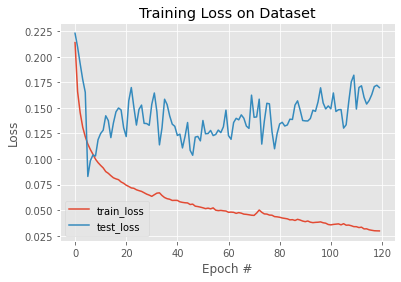

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

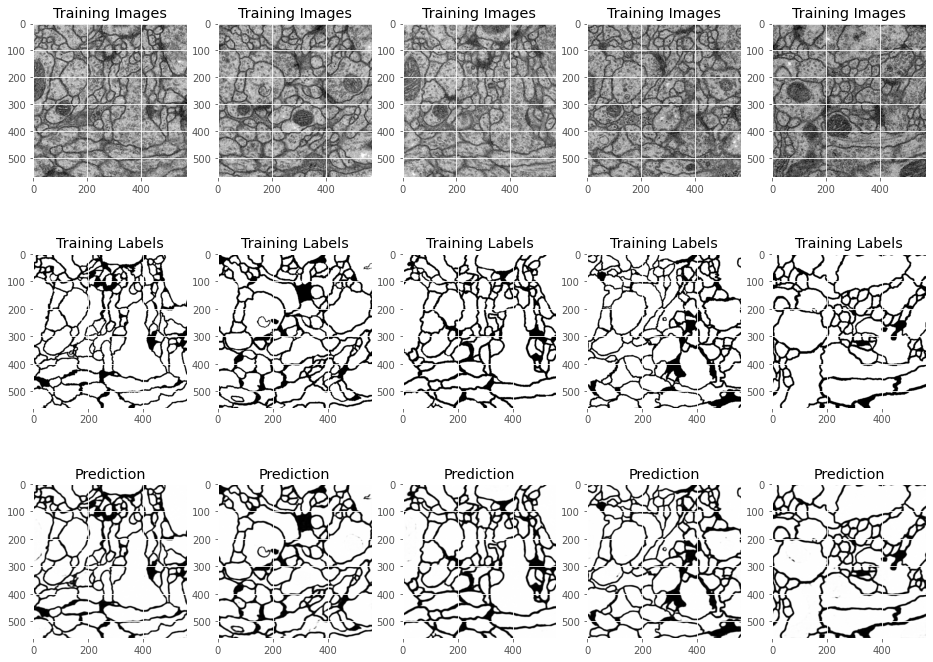

In [ ]:
# Visualizing train set
t_images, t_labels = next(iter(train_dataloader))

with torch.no_grad():
    # setting model to evaluation mode
    model.eval()

    # iterating over train dataloader
    t_images,t_labels = t_images.to(device),t_labels.to(device)

    # forward pass
    logits = model(t_images)


# Create a figure with a grid of subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=BATCH,figsize=(16, 12))

# Plot the images in the subplots
for i, ax in enumerate(ax1):
    # Get the image and label for the current subplot
    image = t_images[i].cpu()

    ax.imshow(image[0],cmap='gray')
    ax.title.set_text("Training Images")

    
# Plot the images in the subplots
for i, ax in enumerate(ax2):
    # Get the image and label for the current subplot
    image = t_labels[i].cpu()

    ax.imshow(image[0],cmap='gray')
    ax.title.set_text("Training Labels")

# Plot the images in the subplots
for i, ax in enumerate(ax3):
    # Get the image and label for the current subplot
    image = torch.sigmoid(logits[i].cpu())

    ax.imshow(image[0],cmap='gray')
    ax.title.set_text("Prediction")

# Show the plot
plt.show()

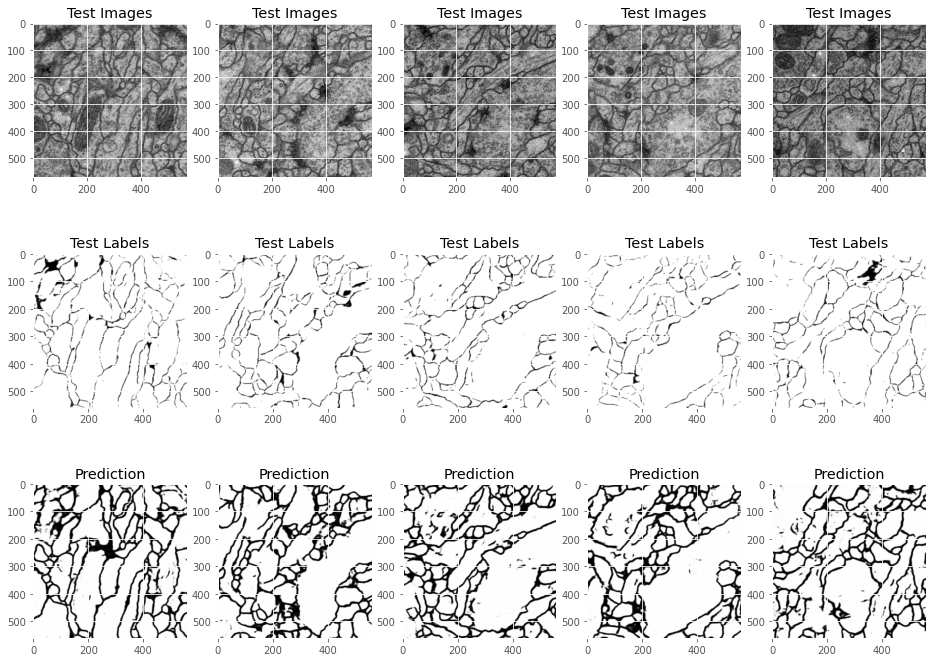

In [ ]:
# Visualizing test set
t_images, t_labels = next(iter(test_dataloader))

with torch.no_grad():
    # setting model to evaluation mode
    model.eval()

    # iterating over test dataloader
    t_images,t_labels = t_images.to(device),t_labels.to(device)

    # forward pass
    logits = model(t_images)


# Create a figure with a grid of subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=BATCH,figsize=(16, 12))


# Plot the images in the subplots
for i, ax in enumerate(ax1):
    # Get the image and label for the current subplot
    image = t_images[i].cpu()

    ax.imshow(image[0],cmap='gray')
    ax.title.set_text("Test Images")
    
# Plot the images in the subplots
for i, ax in enumerate(ax2):
    # Get the image and label for the current subplot
    image = t_labels[i].cpu()

    ax.imshow(image[0],cmap='gray')
    ax.title.set_text("Test Labels")

# Plot the images in the subplots
for i, ax in enumerate(ax3):
    # Get the image and label for the current subplot
    image = torch.sigmoid(logits[i].cpu())

    ax.imshow(image[0],cmap='gray')
    ax.title.set_text("Prediction")

# Show the plot
plt.show()